In [2]:
from keras.src.utils import pad_sequences, to_categorical
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.model_selection import train_test_split

# Path to extracted zip
DATA_DIR = "combined_extracted/combined"  # folder containing all .txt files after extracting combined.zip

X, y = [], []

# --- Read all gesture files ---
for file in os.listdir(DATA_DIR):
    if file.endswith(".txt"):
        gesture = file.split("_")[0]  # e.g., 'wave_front_p1.txt' → 'wave'
        path = os.path.join(DATA_DIR, file)
        data = np.loadtxt(path)

        # Ensure correct shape (timesteps, 60)
        if data.shape[1] != 60:
            print(f"Skipping {file}, unexpected shape {data.shape}")
            continue

        X.append(data)
        y.append(gesture)

print(f"✅ Loaded {len(X)} gesture samples")

# --- Normalize feature values ---
scaler = StandardScaler()
X_scaled = [scaler.fit_transform(sample) for sample in X]

# --- Pad sequences ---
X_padded = pad_sequences(X_scaled, padding='post', dtype='float32')

# --- Encode gesture labels ---
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

# --- Split dataset ---
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y_cat, test_size=0.2, random_state=42, stratify=y_cat
)

print("✅ Data ready:")
print("Train:", X_train.shape, " Test:", X_test.shape)


✅ Loaded 2700 gesture samples
✅ Data ready:
Train: (2160, 189, 60)  Test: (540, 189, 60)


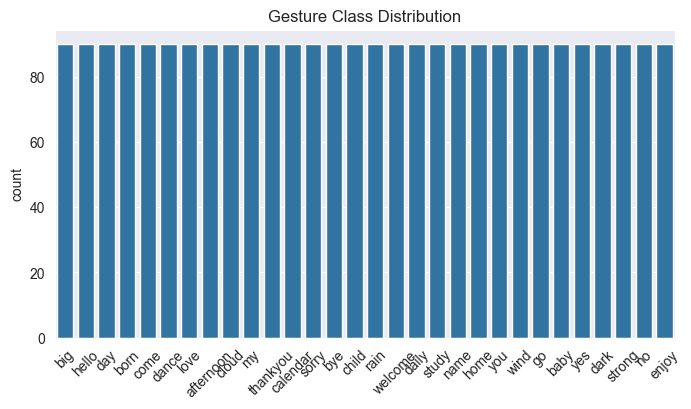

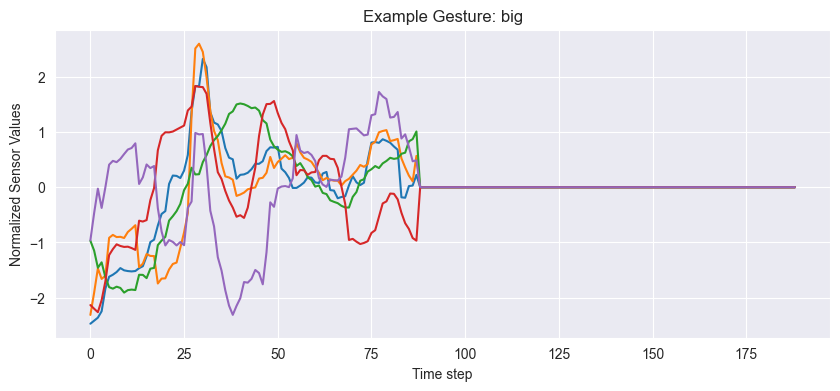

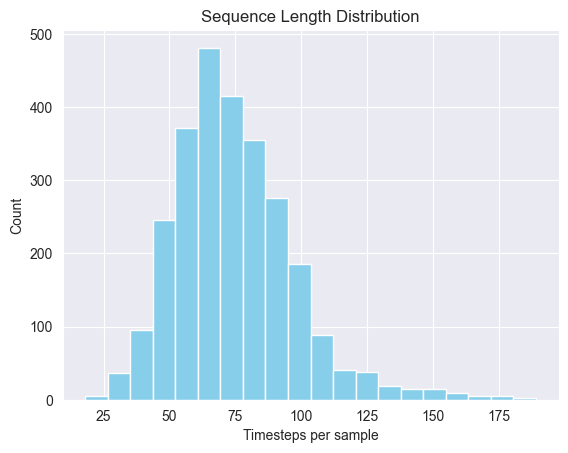

In [3]:
# Visualize gesture distribution
plt.figure(figsize=(8, 4))
sns.countplot(x=y)
plt.title("Gesture Class Distribution")
plt.xticks(rotation=45)
plt.show()

# Visualize one sample’s sensor data
sample_idx = 0
plt.figure(figsize=(10, 4))
plt.plot(X_padded[sample_idx][:, :5])  # plot first 5 features
plt.title(f"Example Gesture: {y[sample_idx]}")
plt.xlabel("Time step")
plt.ylabel("Normalized Sensor Values")
plt.show()

# Visualize sequence length distribution
lengths = [len(x) for x in X]
plt.hist(lengths, bins=20, color='skyblue')
plt.title("Sequence Length Distribution")
plt.xlabel("Timesteps per sample")
plt.ylabel("Count")
plt.show()


In [9]:


from keras.src.callbacks import EarlyStopping
from keras.src.layers import Bidirectional, LSTM, Dropout, Dense
from keras import Sequential

num_classes = y_cat.shape[1]
timesteps = X_padded.shape[1]
features = X_padded.shape[2]

model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(timesteps, features)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# --- Early stopping ---
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# --- Train the model ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    callbacks=[es],
    verbose=1
)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ (None, 189, 256)       │       193,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 189, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 30)             │         1,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 368,094 (1.40 MB)

 Trainable params: 368,094 (1.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 30s 209ms/step - accuracy: 0.0468 - loss: 3.3993 - val_accuracy: 0.1241 - val_loss: 3.2201
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 37s 277ms/step - accuracy: 0.1526 - loss: 3.0545 - val_accuracy: 0.2259 - val_loss: 2.7490
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 37s 272ms/step - accuracy: 0.2717 - loss: 2.5128 - val_accuracy: 0.2704 - val_loss: 2.5137
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 37s 274ms/step - accuracy: 0.4062 - loss: 2.0405 - val_accuracy: 0.3130 - val_loss: 2.3202
Epoch 5/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 37s 275ms/step - accuracy: 0.4846 - loss: 1.6410 - val_accuracy: 0.3426 - val_loss: 2.2338
Epoch 6/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 39s 289ms/step - accuracy: 0.5475 - loss: 1.4560 - val_accuracy: 0.3759 - val_loss: 2.2367
Epoch 7/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 38s 279ms/step - accuracy: 0.6164 - loss: 1.2077 - val_accuracy: 0.3963 - val_loss: 2.1142
Epoch 8/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 38s 283ms/step - accuracy: 0.6973 - loss: 0

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step
Classification Report:
              precision    recall  f1-score   support

   afternoon       0.08      0.06      0.07        18
        baby       0.56      0.56      0.56        18
         big       0.25      0.33      0.29        18
        born       0.76      0.72      0.74        18
         bye       0.07      0.11      0.09        18
    calendar       0.67      0.44      0.53        18
       child       0.70      0.39      0.50        18
       cloud       0.58      0.78      0.67        18
        come       0.08      0.06      0.06        18
       daily       0.79      0.61      0.69        18
       dance       0.65      0.61      0.63        18
        dark       0.78      0.78      0.78        18
         day       0.50      0.44      0.47        18
       enjoy       0.60      0.50      0.55        18
          go       0.52      0.67      0.59        18
       hello       0.22      0.28      0.24        18
        home     

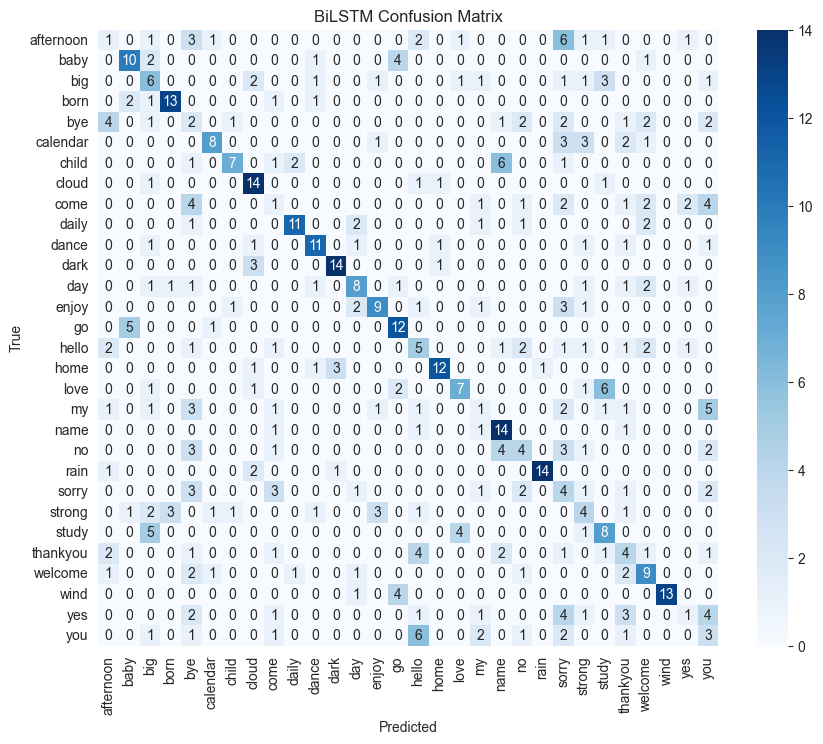

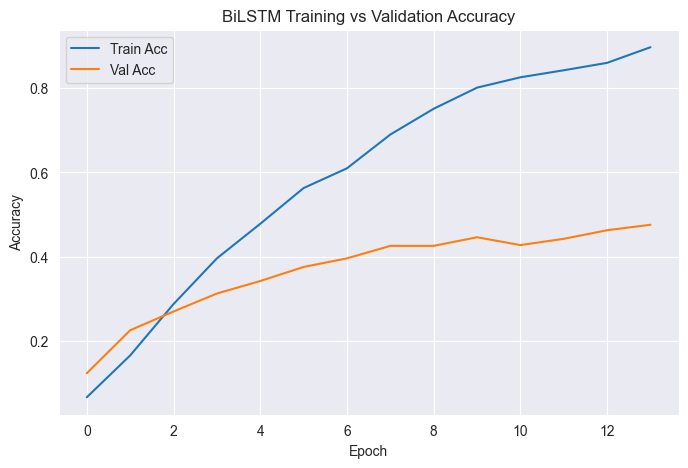

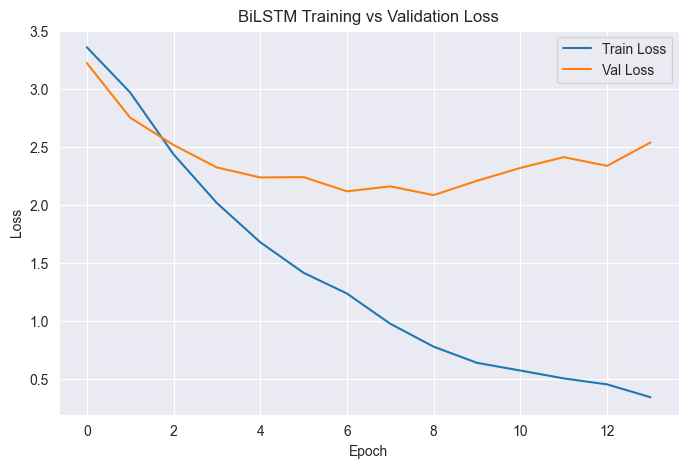

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Accuracy and classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("BiLSTM Confusion Matrix")
plt.show()

# Training curves
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("BiLSTM Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("BiLSTM Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
